In [1]:
%load_ext dotenv
%dotenv

In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [3]:
class State(MessagesState):
    summary: str

In [4]:
chat = ChatOpenAI(model = "gpt-4o", 
                  seed = 365, 
                  temperature = 0, 
                  max_completion_tokens = 100)

In [5]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [6]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
        
    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}
    
    Keep this in mind as you answer the next question.
    '''
    
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [7]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
    
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below. 
Build upon the previous summary rather than repeating it, 
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

In [8]:
graph = StateGraph(State)

In [9]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

In [10]:
db_path = "C:/Users/matsv/PyCharm/ai_engineer_course_notes/LangGraph/langgraph.db"
con = sqlite3.connect(database = db_path, check_same_thread = False)

In [11]:
checkpointer = SqliteSaver(con)

In [12]:
graph_compiled = graph.compile(checkpointer = checkpointer)

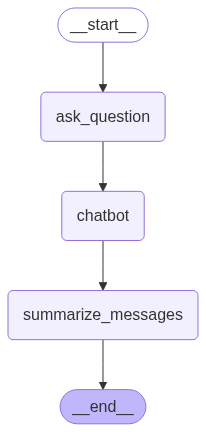

In [13]:
graph_compiled

In [14]:
config1 = {"configurable": {"thread_id": "1"}}

In [15]:
graph_compiled.invoke(State(), config1)


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

Guido van Rossum was born in The Hague, Netherlands.

-------> ENTERING summarize_messages:

Update the ongoing summary by incorporating the new lines of conversation below. 
Build upon the previous summary rather than repeating it, 
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
Guido van Rossum is the creator of Python, having started work on it in the late 1980s, with its first release in 1991.

New Conversation:
ai: What is your question?

human: where was he born?

ai: Guido van Rossum was born in The Hague, Netherlands.





{'messages': [],
 'summary': 'Guido van Rossum, the creator of Python, began developing the language in the late 1980s, with its first release in 1991. He was born in The Hague, Netherlands.'}